In [1]:
from concurrent.futures import ProcessPoolExecutor

from genius_square import Dice, Side
from genius_square.experimental import GameState, Solver  # These are the rust replacements
from tqdm import tqdm

In [2]:
# First we take a random roll of the dice.
dice = Dice()
sides = dice.roll()
sides

[Side("F1"),
 Side("C4"),
 Side("E2"),
 Side("B1"),
 Side("E6"),
 Side("C5"),
 Side("E1")]

In [3]:
# Visualise the board with just the blockers
blocker_mask = sum(sides)
state = GameState(blocker_mask)
state

🫥🫥🫥🫥🫥🫥
🔘🫥🫥🫥🫥🫥
🫥🫥🫥🔘🔘🫥
🫥🫥🫥🫥🫥🫥
🔘🔘🫥🫥🫥🔘
🔘🫥🫥🫥🫥🫥

In [4]:
# Now we solve the game and redisplay the state.
solver = Solver()
solver.solve(state)
state

🟫🟫🟨🟧🟧🟧
🔘🟥🟨🟨🟦🟦
🟥🟥🟨🔘🔘🟦
🟥⬜️⬜️⬜️⬜️🟦
🔘🔘🟪🟩🟩🔘
🔘🟪🟪🟩🟩⬛️

In [5]:
# Creating a custom board from cooordinates
coords = ["F1", "B4", "A1", "C2", "E6", "C6", "E1"]
sides = [Side(coord) for coord in coords]
blocker_mask = sum(sides)
state = GameState(blocker_mask)
solver.solve(state)
state

🔘⬜️⬜️⬜️⬜️🟥
🟧🟫🟫🔘🟥🟥
🟧🔘🟨🟦🟥🔘
🟧🟨🟨🟦🟦🟦
🔘🟪🟨🟩🟩🔘
🔘🟪🟪🟩🟩⬛️

In [11]:
# Validate all possible dice rolls
def solve_mask(mask: int) -> None:
    solver = Solver()
    state = GameState(mask)
    solver.solve(state)


masks = dice.all_bitmasks()
with ProcessPoolExecutor() as executor:
    list(tqdm(executor.map(solve_mask, masks, chunksize=64), total=len(masks)))

print(f"All {len(masks):,} possible combinations solved. ✨")

100%|██████████| 62208/62208 [00:00<00:00, 344362.86it/s]

All 62,208 possible combinations solved. ✨


In [7]:
# Calculate the number of valid solutions for all possible dice rolls.
def count_mask(mask: int) -> tuple[int, int]:
    solver = Solver()
    state = GameState(mask)
    soln_count = solver.count_solns(state)
    return mask, soln_count


masks = dice.all_bitmasks()
with ProcessPoolExecutor() as executor:
    results = list(tqdm(executor.map(count_mask, masks, chunksize=16), total=len(masks)))
    results = sorted(results, key=lambda x: (x[1], x[0]))

count_by_mask = dict(results)

100%|██████████| 62208/62208 [00:27<00:00, 2303.44it/s]


If you have polars and seaborn, you can visualize the distribution of possible solutions.

statistic,mask,soln_count
str,f64,f64
"""count""",62208.0,62208.0
"""null_count""",0.0,0.0
"""mean""",2.4796e13,1936.486497
"""std""",1.9517e13,1981.034039
"""min""",3.3555503e7,11.0
"""25%""",2.4052e12,715.0
"""50%""",3.5184e13,1340.0
"""75%""",3.7590e13,2414.0
"""max""",6.7105e13,22317.0


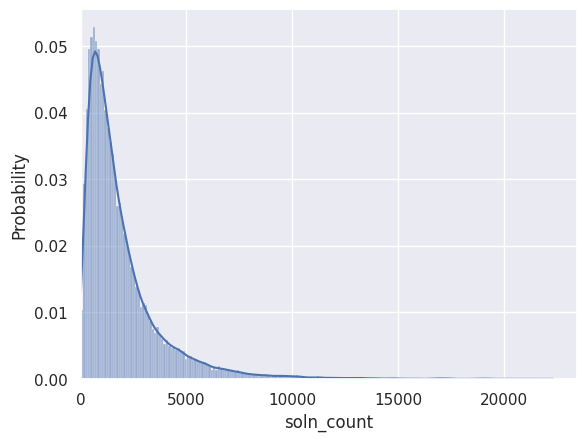

In [8]:
from pathlib import Path

import polars as pl
import seaborn as sns

sns.set_theme()

# Load the results into a DataFrame...
df = pl.DataFrame(
    {
        "mask": count_by_mask.keys(),
        "soln_count": count_by_mask.values(),
    }
).sort("soln_count", "mask")

# NOTE ...or just read from data if you have it.
# data_path = Path("..") / "data" / "solutions.csv"
# df = pl.read_csv(data_path)

ax = sns.histplot(df, x="soln_count", bins=200, kde=True, stat="probability")
ax.set_xlim(0, None)
df.describe()

In [9]:
# The 'hardest' puzzle to solve.
hardest_mask = df["mask"][1]
print(f'Configuration with {df['soln_count'][1]} solutions.')
GameState(hardest_mask)

Configuration with 11 solutions.


🫥🫥🫥🫥🫥🔘
🔘🫥🫥🫥🔘🫥
🫥🫥🫥🫥🫥🫥
🔘🫥🫥🫥🫥🫥
🫥🫥🔘🫥🫥🫥
🫥🔘🫥🔘🫥🫥

In [10]:
# The 'easiest' puzzle to solve.
easiest_mask = df["mask"][-1]
print(f'Configuration with {df['soln_count'][-1]:,} solutions.')
GameState(easiest_mask)

Configuration with 22,317 solutions.


🔘🫥🔘🔘🔘🔘
🫥🫥🫥🫥🫥🫥
🫥🫥🫥🫥🫥🫥
🫥🫥🫥🫥🫥🫥
🫥🫥🔘🔘🫥🫥
🫥🫥🫥🫥🫥🫥